In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(0)
N = 200
x = np.arange(1, N+1) / N
eps = np.random.normal(0, np.sqrt(0.01), size=N)
y = 2 * x + 1 + eps

In [3]:
x = np.hstack([np.ones((N, 1)), x.reshape(-1, 1)])
l = lambda w, x, y: np.mean((y - x @ w) ** 2)
grad_l = lambda w, x, y: -2 * x.T @ (y - x @ w) / len(y)

def gradient_descent(l, grad_l, Theta0, X, Y, lr=1e-3, epochs=500):
    Theta = Theta0
    losses = []
    thetas = []
    for k in range(epochs):
        grad = grad_l(Theta, X, Y)
        Theta -= lr * grad
        losses.append(l(Theta, X, Y))
        thetas.append(Theta.copy())
    return thetas, losses

def sgd(l, grad_l, Theta0, X, Y, batch_size=64, lr=1e-3, epochs=500):
    Theta = Theta0
    N = len(Y)
    losses = []
    thetas = []
    for epoch in range(epochs):
        indices = np.random.permutation(N)
        for start in range(0, N, batch_size):
            batch_idx = indices[start:start+batch_size]
            Xb, Yb = X[batch_idx], Y[batch_idx]
            grad = grad_l(Theta, Xb, Yb)
            Theta -= lr * grad
        losses.append(l(Theta, X, Y))
        thetas.append(Theta.copy())
    return thetas, losses

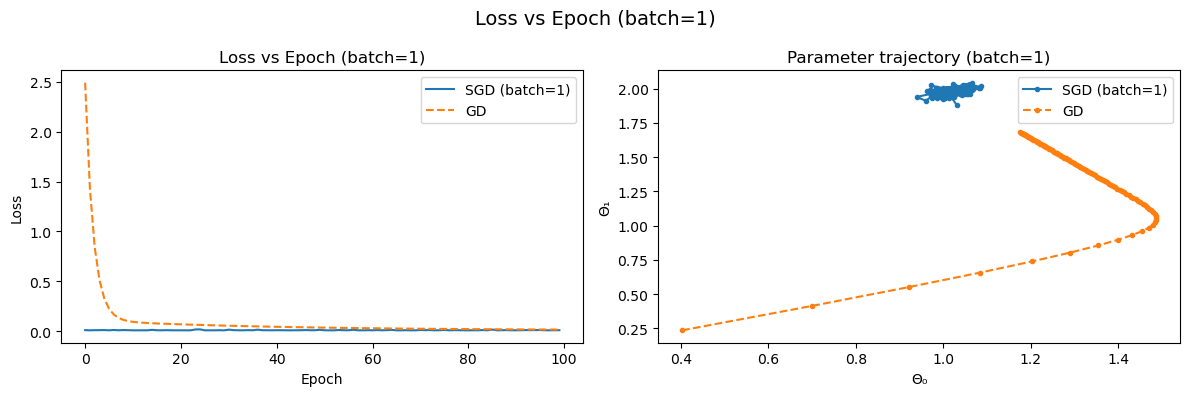

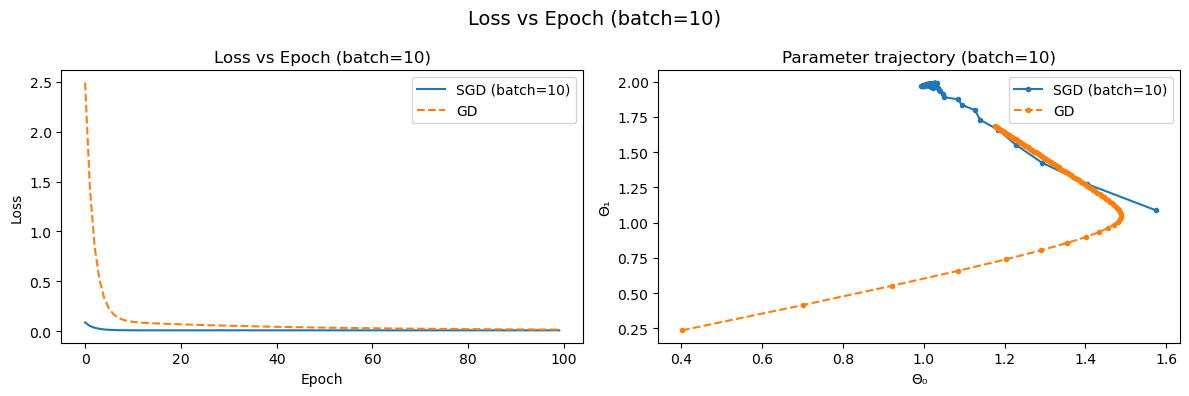

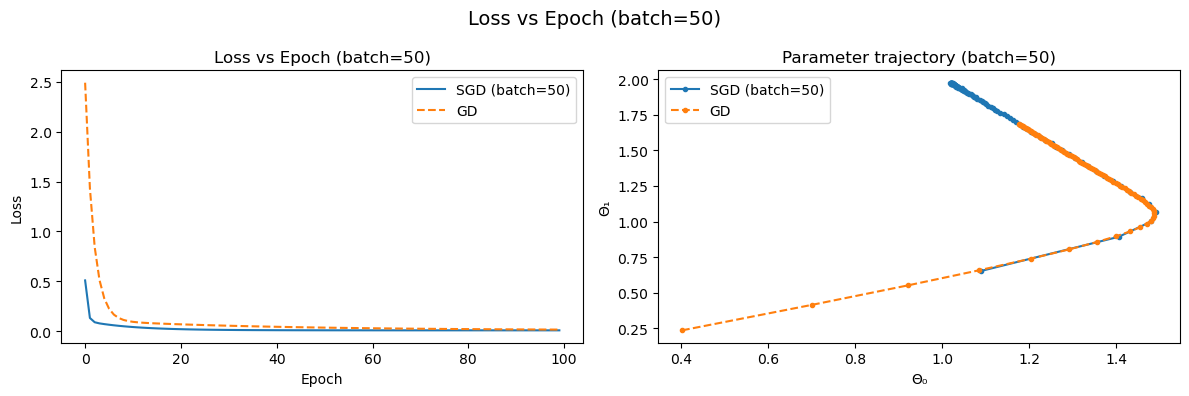

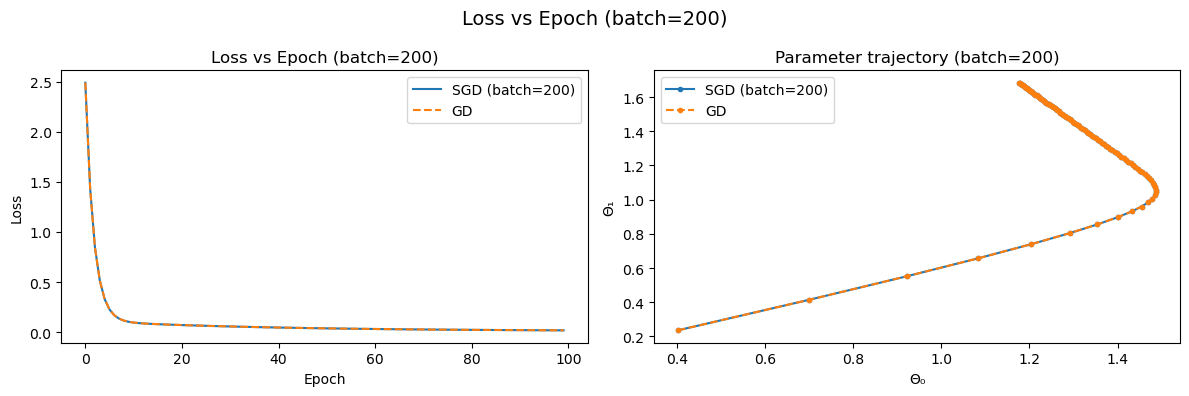

In [4]:
thetasGD, lossesGD = gradient_descent(l, grad_l, np.zeros(2), x, y, lr=0.1, epochs=100)
batches = [1, 10, 50, N]
for batch_size in batches:
    thetasSGD, lossesSGD = sgd(l, grad_l, np.zeros(2), x, y, batch_size=batch_size, lr=0.1, epochs=100)
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'Loss vs Epoch (batch={batch_size})', fontsize=14)

    axes[0].plot(lossesSGD, label=f'SGD (batch={batch_size})')
    axes[0].plot(lossesGD, label='GD', linestyle='--')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title(f'Loss vs Epoch (batch={batch_size})')
    axes[0].legend()

    axes[1].plot([th[0] for th in thetasSGD], [th[1] for th in thetasSGD], 'o-', label=f'SGD (batch={batch_size})', markersize=3)
    axes[1].plot([th[0] for th in thetasGD], [th[1] for th in thetasGD], 'o--', label='GD', markersize=3)
    axes[1].set_xlabel('Θ₀')
    axes[1].set_ylabel('Θ₁')
    axes[1].set_title(f'Parameter trajectory (batch={batch_size})')   
    axes[1].legend()
    plt.tight_layout()
    plt.show()

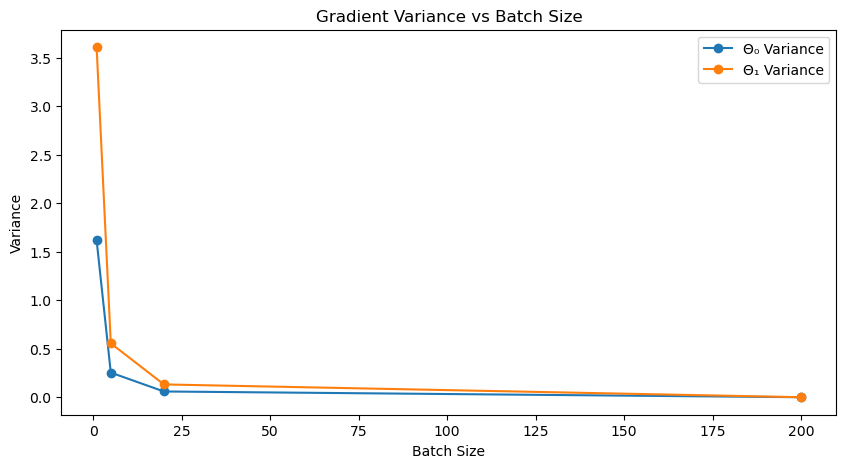

In [5]:
theta = np.zeros(2)
batch_sizes = [1, 5, 20, N]
variances = []
for batch_size in batch_sizes:
    g = []
    for i in range(100):
        indices = np.random.choice(N, size=batch_size, replace=False)
        X, Y = x[indices], y[indices]
        gk = grad_l(theta, X, Y)
        g.append(gk)
    g_array = np.array(g)
    variance = np.var(g_array, axis=0)
    variances.append(variance)
plt.figure(figsize=(10, 5))
plt.plot(batch_sizes, variances, 'o-')
plt.xlabel('Batch Size')
plt.ylabel('Variance')
plt.title('Gradient Variance vs Batch Size')
plt.legend(['Θ₀ Variance', 'Θ₁ Variance'])
plt.show()

    

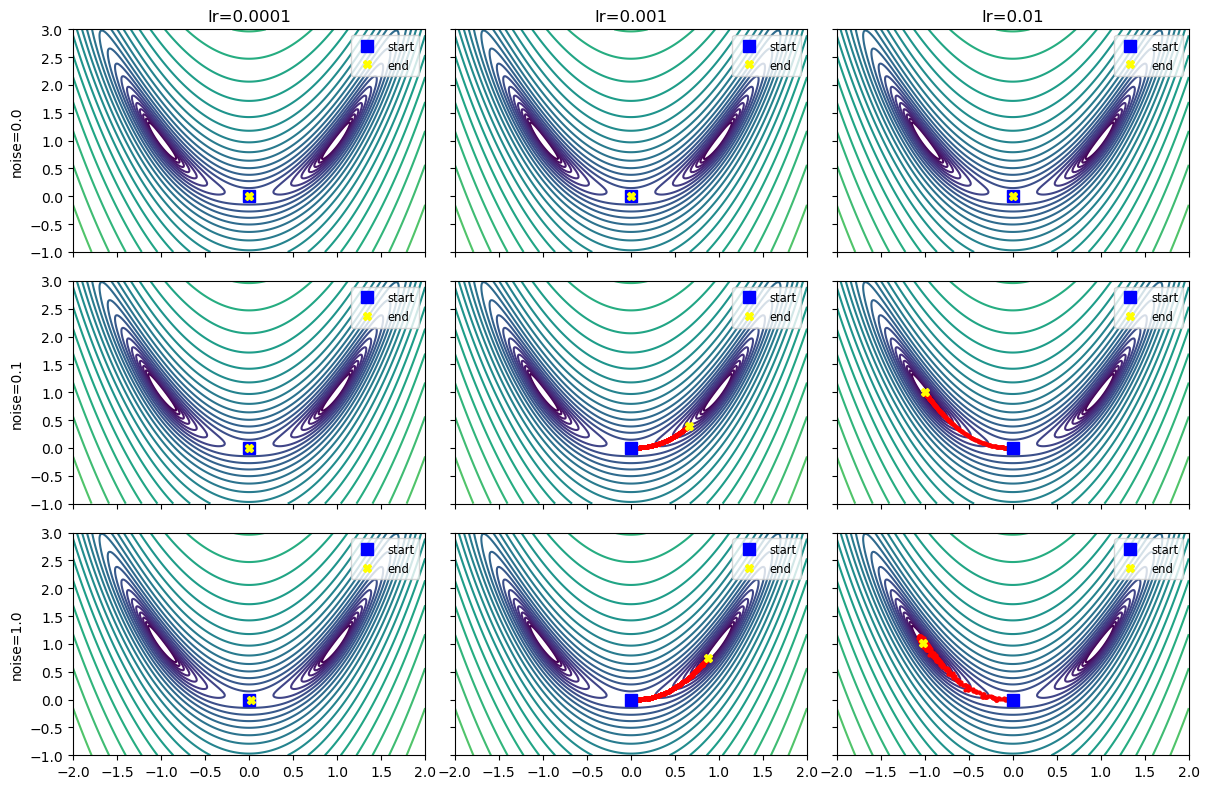

In [6]:
from matplotlib.colors import LogNorm

l_2D = lambda w0, w1: (w0**2 - 1)**2 + 10 * (w1 - w0**2)**2
grad_l_2D = lambda w: np.array([
    4 * (w[0]**2 - 1) * w[0] + 40 * (w[0]**2 - w[1]) * w[0],
    20 * (w[1] - w[0]**2)
])
noise_grad_l_2D = lambda w, noise_level=1.0: grad_l_2D(w) + np.random.normal(0, noise_level, size=w.shape)

def sgd_2D(l, noise_grad_l, Theta0, lr=1e-3, epochs=1000, noise_level=1.0):
    Theta = Theta0
    losses = []
    thetas = []
    for k in range(epochs):
        grad = noise_grad_l(Theta, noise_level)
        Theta -= lr * grad
        losses.append(l(Theta[0], Theta[1]))
        thetas.append(Theta.copy())
    return thetas, losses

# level set grid
w0 = np.linspace(-2, 2, 400)
w1 = np.linspace(-1, 3, 400)
W0, W1 = np.meshgrid(w0, w1)
Z = (W0**2 - 1)**2 + 10 * (W1 - W0**2)**2

# experiment setup
Theta0 = np.array([0.0, 0.0])
lrs = [1e-4, 1e-3, 1e-2]
noise_levels = [0.0, 0.1, 1.0]
epochs = 2000

fig, axes = plt.subplots(len(noise_levels), len(lrs), figsize=(12, 8), sharex=True, sharey=True)

levels = np.logspace(-1, 3.5, 30)
for i, noise in enumerate(noise_levels):
    for j, lr in enumerate(lrs):
        ax = axes[i, j]
        ax.contour(W0, W1, Z, levels=levels, norm=LogNorm(), cmap='viridis')
        thetas, losses = sgd_2D(l_2D, noise_grad_l_2D, Theta0.copy(), lr=lr, epochs=epochs, noise_level=noise)
        th = np.array(thetas)
        ax.plot(th[:, 0], th[:, 1], '-o', color='red', markersize=2, linewidth=1)
        ax.plot(Theta0[0], Theta0[1], 's', color='blue', markersize=8, label='start')
        ax.plot(th[-1, 0], th[-1, 1], 'X', color='yellow', markersize=6, label='end')
        if i == 0:
            ax.set_title(f'lr={lr}')
        if j == 0:
            ax.set_ylabel(f'noise={noise}')
        ax.set_xlim(w0.min(), w0.max())
        ax.set_ylim(w1.min(), w1.max())
        ax.legend(loc='upper right', fontsize='small')

plt.tight_layout()
plt.show()


In [8]:
import numpy as np
import pandas as pd

In [13]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "insurance.csv"

# Load the latest version
df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "mirichoi0218/insurance",
  file_path,
)

print("First 5 records:", df.head())

First 5 records:    age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


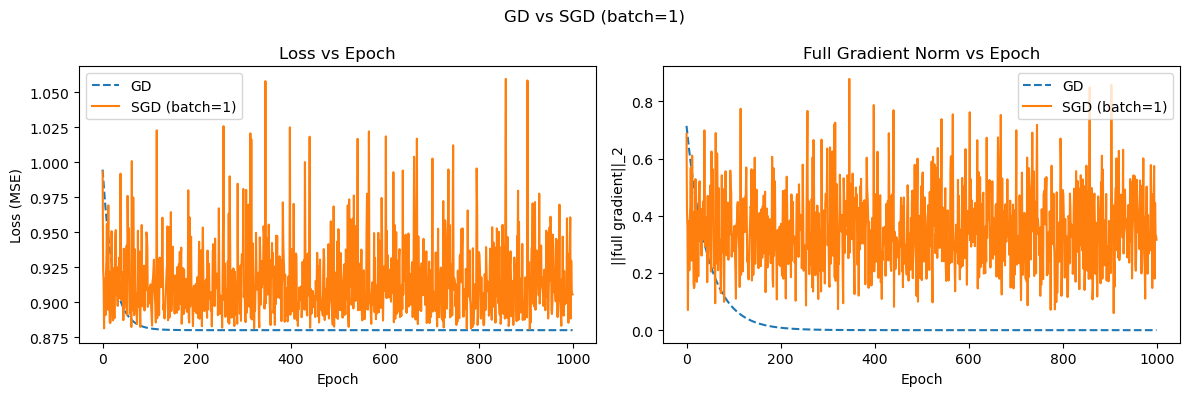

GD final Theta: [1.23999797e-17 2.78440109e-01 1.67225810e-01 5.40395370e-02]
SGD (batch=1) final Theta: [-0.05392873  0.31142567  0.06169307  0.16004374]


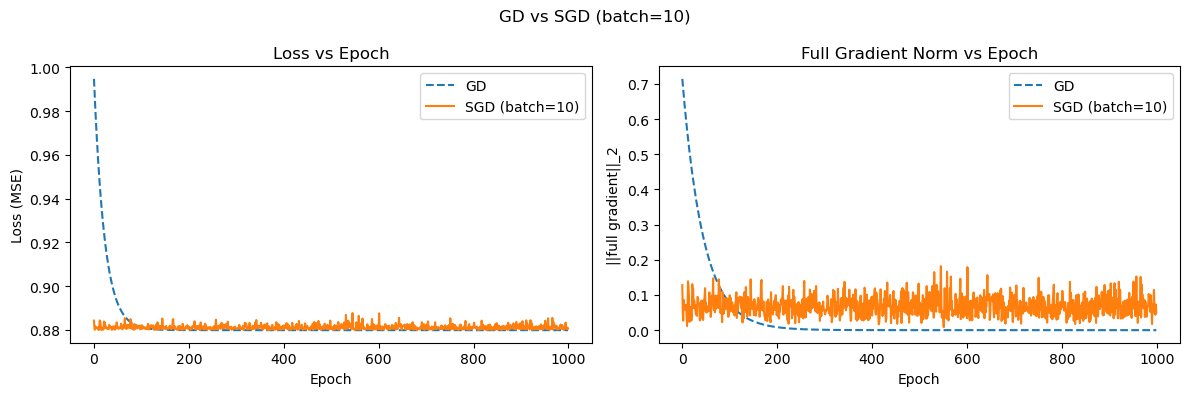

GD final Theta: [1.23999797e-17 2.78440109e-01 1.67225810e-01 5.40395370e-02]
SGD (batch=10) final Theta: [-0.00932535  0.30113316  0.16353321  0.04707491]


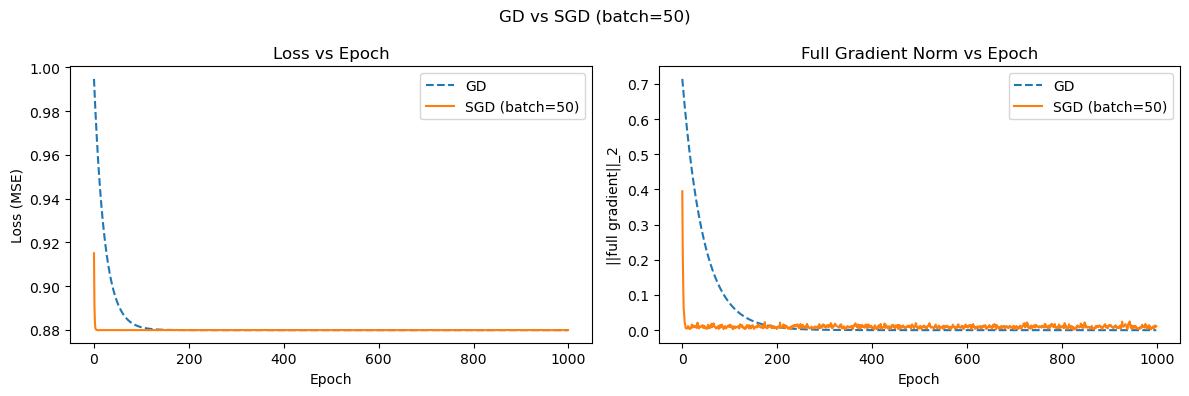

GD final Theta: [1.23999797e-17 2.78440109e-01 1.67225810e-01 5.40395370e-02]
SGD (batch=50) final Theta: [0.00276777 0.27424702 0.16635586 0.05238772]


In [16]:
features = ['age', 'bmi', 'children']
X = df[features].values
Y = df['charges'].values

X_mean, X_std = X.mean(axis=0), X.std(axis=0)
Y_mean, Y_std = Y.mean(), Y.std()

X = (X - X_mean) / X_std
Y = (Y - Y_mean) / Y_std

X = np.hstack([np.ones((X.shape[0], 1)), X])

loss_mse = lambda w, X, Y: np.mean((Y - X @ w) ** 2)
grad_loss_mse = lambda w, X, Y: -2 * X.T @ (Y - X @ w) / len(Y)

lr = 1e-2
epochs = 1000
batch_sizes = [1, 10, 50]

Theta0 = np.zeros(X.shape[1])

# run full-batch GD
thetasGD, lossesGD = gradient_descent(loss_mse, grad_loss_mse, Theta0.copy(), X, Y, lr=lr, epochs=epochs)
grad_norms_GD = [np.linalg.norm(grad_loss_mse(theta, X, Y)) for theta in thetasGD]

for batch_size in batch_sizes:
    thetasSGD, lossesSGD = sgd(loss_mse, grad_loss_mse, Theta0.copy(), X, Y, batch_size=batch_size, lr=lr, epochs=epochs)
    grad_norms_SGD = [np.linalg.norm(grad_loss_mse(theta, X, Y)) for theta in thetasSGD]

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'GD vs SGD (batch={batch_size})', fontsize=12)

    # Loss vs epoch
    axes[0].plot(lossesGD, label='GD', linestyle='--')
    axes[0].plot(lossesSGD, label=f'SGD (batch={batch_size})')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss (MSE)')
    axes[0].legend()
    axes[0].set_title('Loss vs Epoch')

    # Full-gradient L2 norm vs epoch
    axes[1].plot(grad_norms_GD, label='GD', linestyle='--')
    axes[1].plot(grad_norms_SGD, label=f'SGD (batch={batch_size})')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('||full gradient||_2')
    axes[1].legend()
    axes[1].set_title('Full Gradient Norm vs Epoch')

    plt.tight_layout()
    plt.show()

    # report final parameters
    print(f'GD final Theta: {thetasGD[-1]}')
    print(f'SGD (batch={batch_size}) final Theta: {thetasSGD[-1]}')
